In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import emcee
from iminuit import Minuit
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [3]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [4]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [5]:
data_dir = "/tigress/ljchang/NPTF_test/Bkg-Maps/fermi_data/"
templates_dir = "/tigress/ljchang/NPTF_test/Bkg-Maps/templates_example/"

In [6]:
fermi_data = np.load(data_dir+"fermidata_counts.npy")
fermi_exposure = np.load(data_dir+"fermidata_exposure.npy")

In [7]:
x_counts, y_counts, error_L, error_H, x_errors_L, x_errors_H = \
[np.array([  1.36887451e-10,   2.56502091e-10,   4.80638086e-10,
          9.00628020e-10,   1.68761248e-09,   3.16227766e-09,
          5.92553098e-09,   1.11033632e-08,   2.08056754e-08,
          3.89860370e-08,   7.30527154e-08]),
 np.array([  1.04000127e+08,   1.83397053e+08,   9.65856820e+07,
          1.51198295e+07,   4.76804443e+06,   9.78677656e+05,
          2.08916332e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 np.array([  2.14237668e+07,   2.08831658e+07,   1.10708578e+07,
          3.18362798e+06,   1.29929969e+06,   4.21069315e+05,
          1.34538182e+05,  -5.57461814e-04,  -2.97500603e-04,
         -1.58767124e-04,  -8.47292389e-05]),
 np.array([  2.63822671e+07,   2.34164673e+07,   1.24232945e+07,
          3.93887993e+06,   1.71404939e+06,   6.58746511e+05,
          2.74201404e+05,   1.02159419e+05,   5.45194091e+04,
          2.90953689e+04,   1.55273233e+04]),
 np.array([  3.68874510e-11,   6.91203483e-11,   1.29518913e-10,
          2.42694796e-10,   4.54765736e-10,   8.52147960e-10,
          1.59676969e-09,   2.99205487e-09,   5.60656455e-09,
          1.05056783e-08,   1.96857231e-08]),
 np.array([  5.04942913e-11,   9.46170829e-11,   1.77295138e-10,
          3.32218719e-10,   6.22517224e-10,   1.16648362e-09,
          2.18577733e-09,   4.09574765e-09,   7.67468330e-09,
          1.43809553e-08,   2.69472846e-08])]

## Load best-fit backgrounds

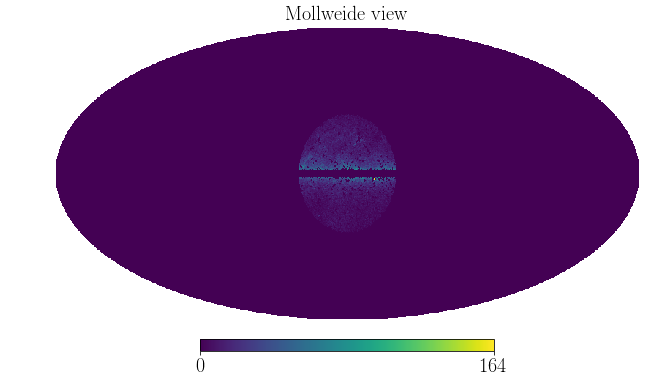

In [8]:
pscmask=np.array(np.load(data_dir+'fermidata_pscmask.npy'), dtype=bool)
analysis_mask = cm.make_mask_total(band_mask = True, band_mask_range = 2,
                                   mask_ring = True, inner = 0, outer = 30,
                                   custom_mask = pscmask)
hp.mollview(~analysis_mask*fermi_data)

In [8]:
best_fit_norms = np.load(templates_dir+"best_fit_norms_band_2_ring_30.npy")
dif = np.load(templates_dir+"dif_band_2_ring_30.npy")
iso = np.load(templates_dir+"iso_band_2_ring_30.npy")
psc = np.load(templates_dir+"psc_band_2_ring_30.npy")
bub = np.load(templates_dir+"bub_band_2_ring_30.npy")
dsk = np.load(templates_dir+"dsk_band_2_ring_30.npy")

In [9]:
best_fit_norms

array([13.56296203,  0.07454446,  1.14704788,  0.95468935,  0.        ])

In [10]:
best_fit_bkg = dif+iso+psc+bub+dsk

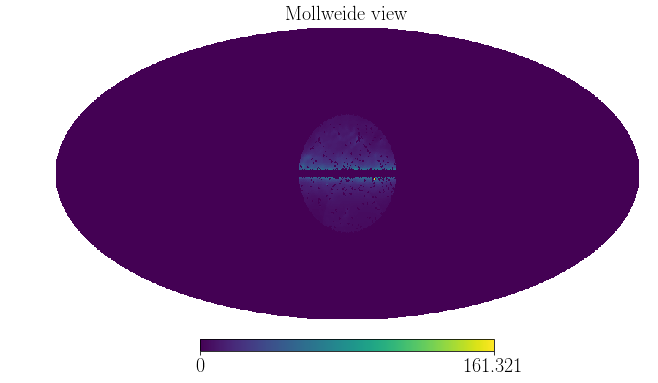

In [11]:
hp.mollview(~analysis_mask*best_fit_bkg)

In [12]:
gce_temp = np.load(data_dir+"template_gce.npy")

In [13]:
np.mean(gce_temp)

0.1380281626977989

## Inject DM

In [9]:
smoothed_Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/JfactorSmoothed/SGH_Jfactor_map_NFW_smoothed.npy')

In [10]:
ebins = 2*np.logspace(-1,3,41)#[7:39+2]

In [11]:
Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')

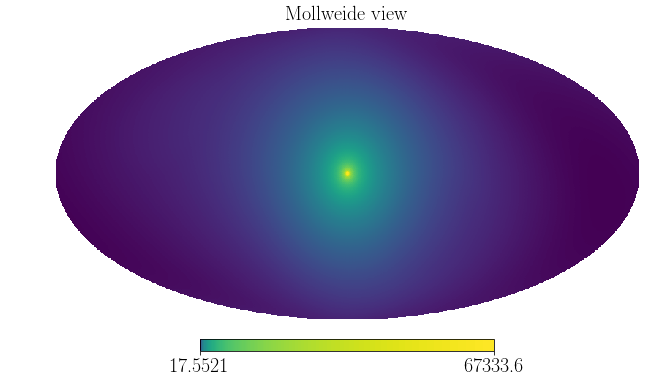

In [58]:
hp.mollview(Jfac_map_NFW*fermi_exposure,norm='log')

In [59]:
xsecs_inj = [1e-26,1e-25,1e-24,1e-23]

In [14]:
# Combine background maps with injected signal, poisson fluctuate to get MCs
file_path = "/tigress/ljchang/NPTF_test/data/"
mchi = 100

particle = pa.Particle(channel='b', m_chi = mchi * GeV)

# for xsec_ind in tqdm(range(len(xsecs_inj))):
for xsec_ind in [0]:
    cross_section = xsecs_inj[xsec_ind]
    inj_sig_map = np.zeros(hp.nside2npix(128))
    inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
    inj_sig_map *= fermi_exposure

#     for MC in tqdm(range(10)):
# #     for MC in [0]:
#         save_tag = 'xbin_' + str(xsec_ind) + '_' + str(MC)
#         sum_data = np.random.poisson(best_fit_bkg+inj_sig_map)
#         np.save(file_path+'injected_signal_MC/'+str(mchi)+'GeV/'+save_tag+'.npy',sum_data)  

#     sum_data = []
#     for ebin in range(emin,emax+1):
#         sum_data.append(fermi_data_ebins[ebin]+np.random.poisson(inj_sig_ebins)[ebin])
#     np.save(file_path+'injected_signal/data/'+str(mchi)+'GeV/xbin_'+str(xsec_ind)+'.npy',sum_data)

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


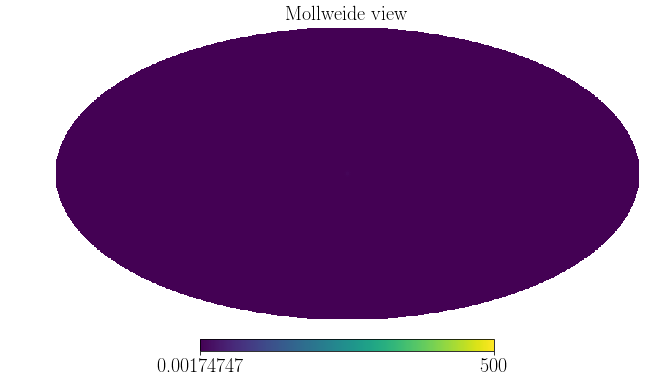

In [18]:
hp.mollview((inj_sig_map),max=500)

In [62]:
chains = (pd.read_csv("/tigress/ljchang/NPTF_test/chains/xbin_0_0/post_equal_weights.dat",header=None,delim_whitespace=True).values)

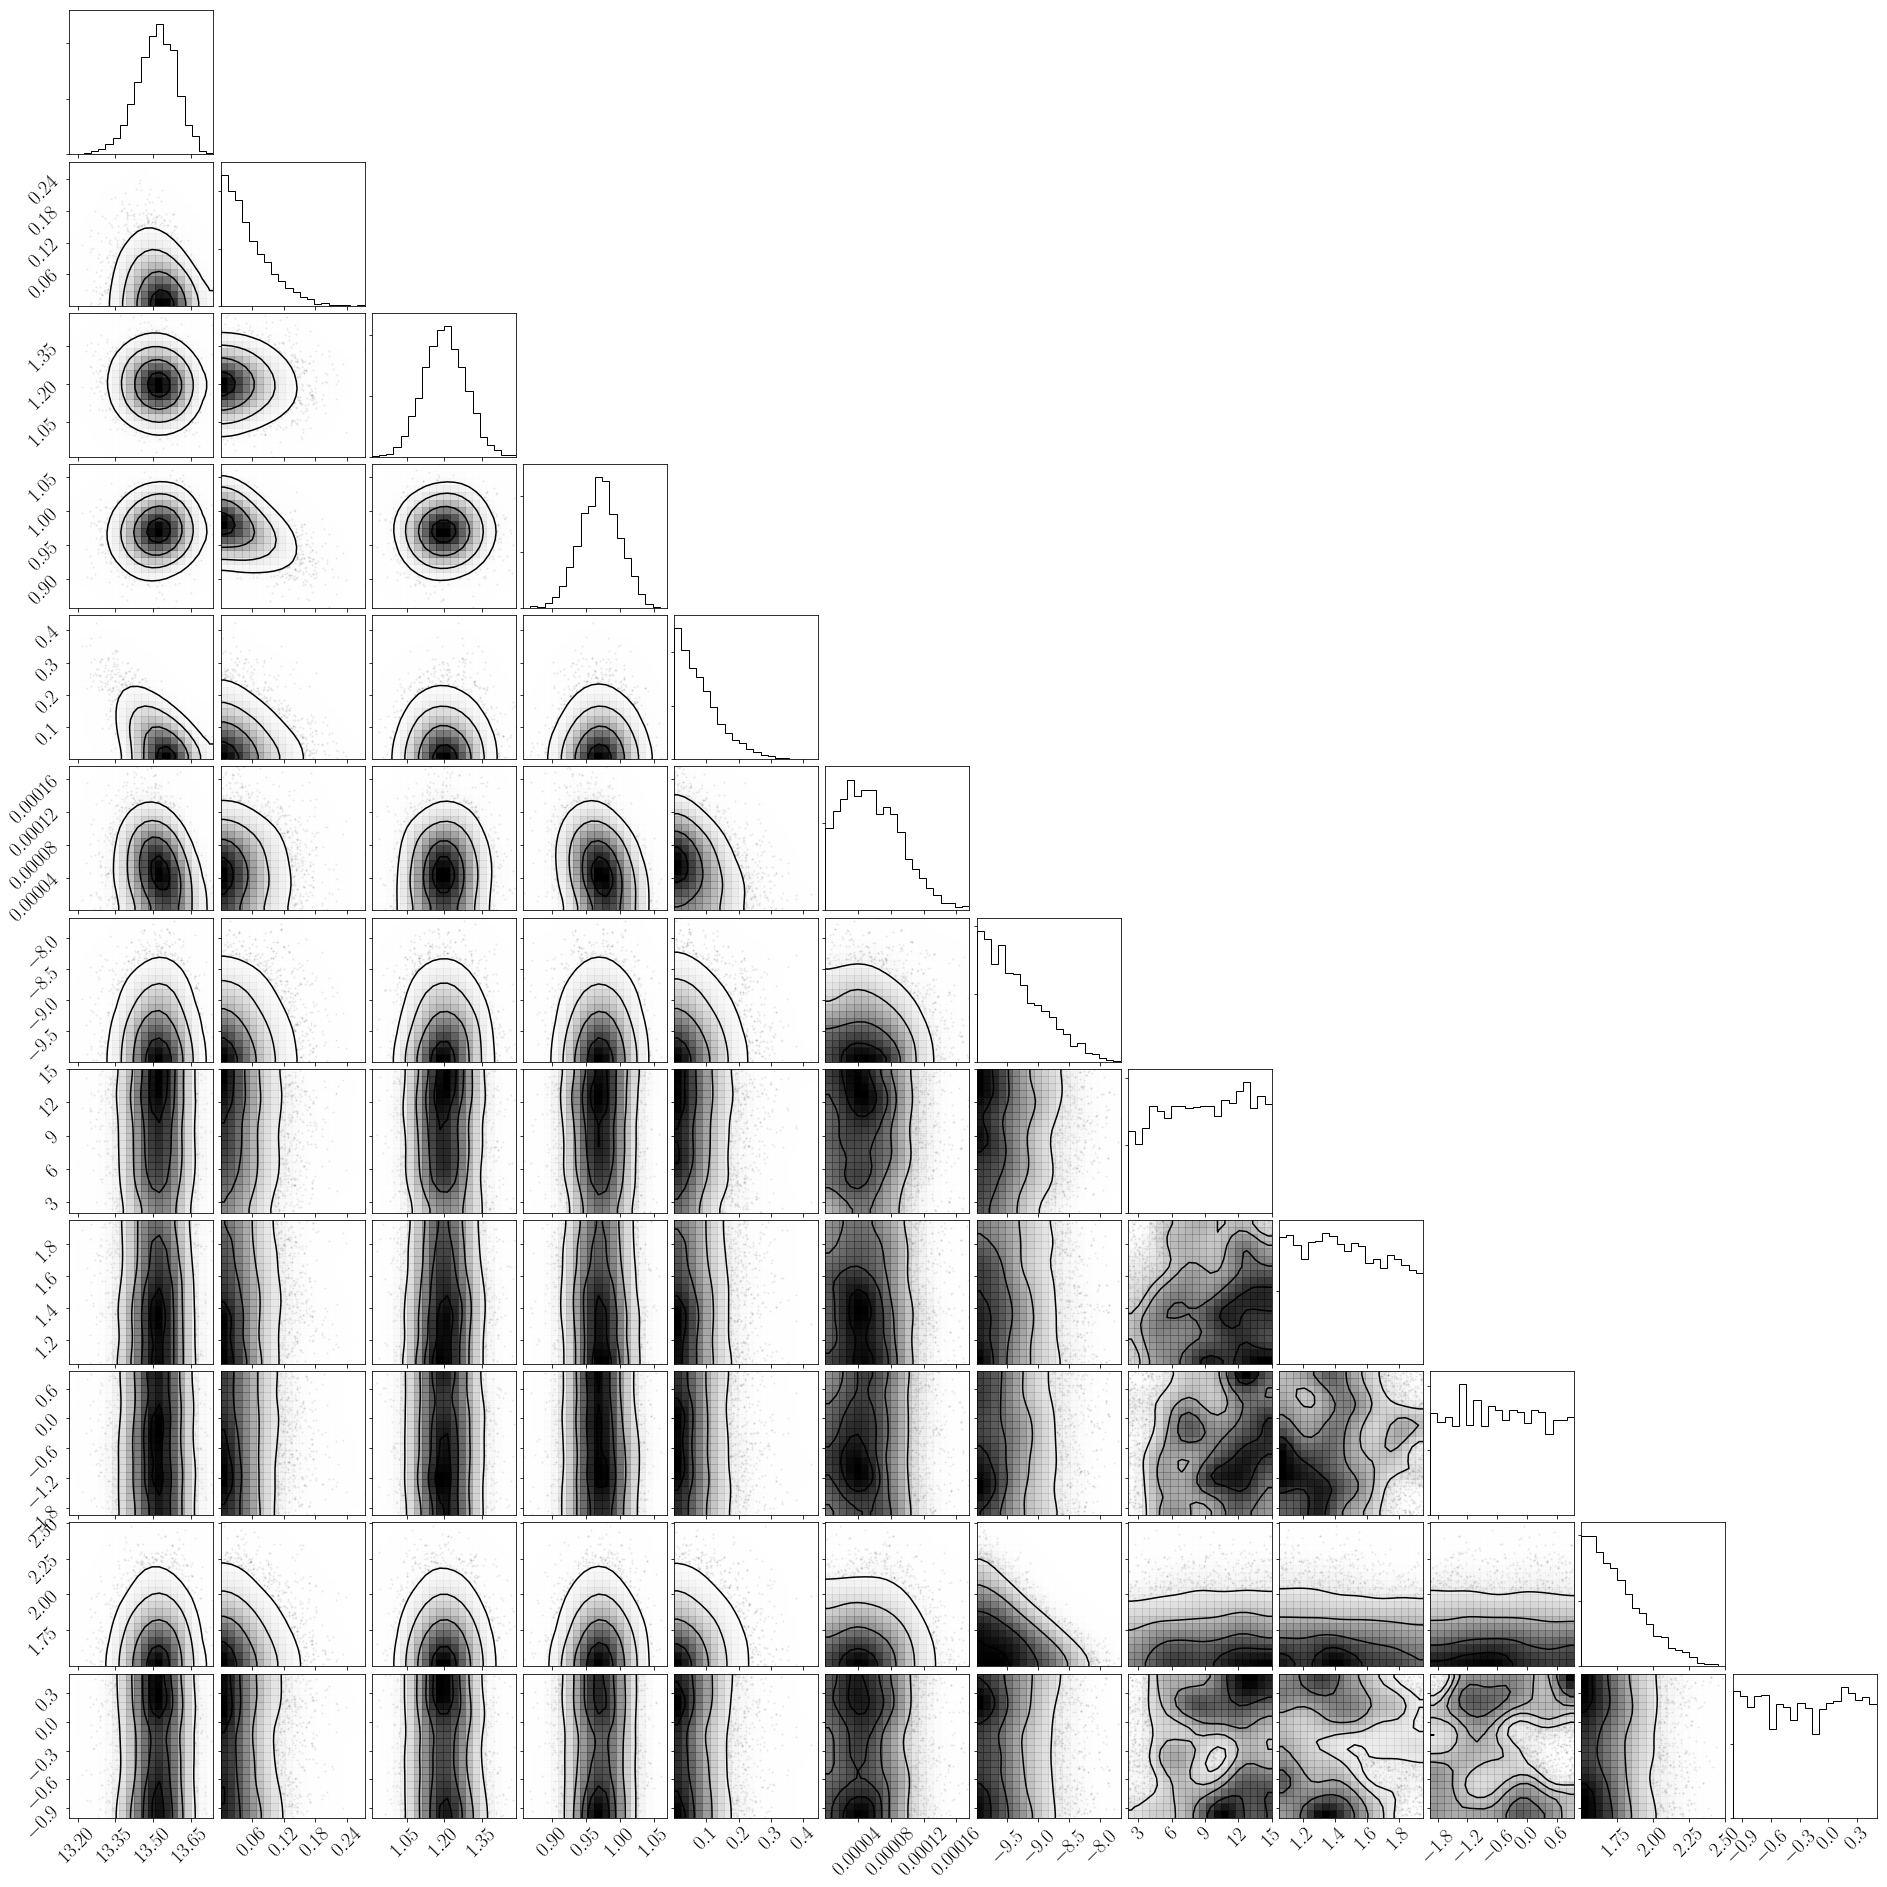

In [67]:
fig = corner.corner(chains[:,:-1],smooth=2)

## GCE test

In [9]:
Jfac_map_NFW_gamma_1p2 = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')

In [10]:
# Combine background maps with injected signal, poisson fluctuate to get MCs
file_path = "/tigress/ljchang/NPTF_test/data/"
mchi = 40

particle = pa.Particle(channel='b', m_chi = mchi * GeV)

cross_section = 2e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW_gamma_1p2*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [11]:
data_dir = "/tigress/ljchang/NPTF_test/Bkg-Maps/fermi_data/"

In [12]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
nfw = Jfac_map_NFW_gamma_1p2*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')

In [63]:
n = nptfit.NPTF(tag="../dm_40GeV_2em26_PStemp_widepriors/")

In [64]:
data = np.random.poisson(inj_sig_map).astype('int32')

In [65]:
n.load_data(data, fermi_exposure)

In [66]:
n.load_mask(analysis_mask)
rescale = fermi_exposure/np.mean(fermi_exposure)
# n.add_template(dsk/rescale, 'dsk_ps', units='PS')
n.add_template(nfw/rescale, 'nfw_ps', units='PS')

In [67]:
n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[1.05,2.95],[-1.95,0.95],[0.3,3.5],[-1.3,0.3]],
                          [True,False,False,False,True,True])

In [68]:
# n.add_template(nfw, 'nfw_dm')
# n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

In [69]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /tigress/ljchang/NPTF_test/Notebooks/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 6


In [ ]:
n.perform_scan(nlive=200)

In [70]:
n.load_scan()

  analysing data from /tigress/ljchang/NPTF_test/Notebooks/chains/../dm_40GeV_2em26_PStemp_widepriors//.txt


In [71]:
an = dnds_analysis.Analysis(n)

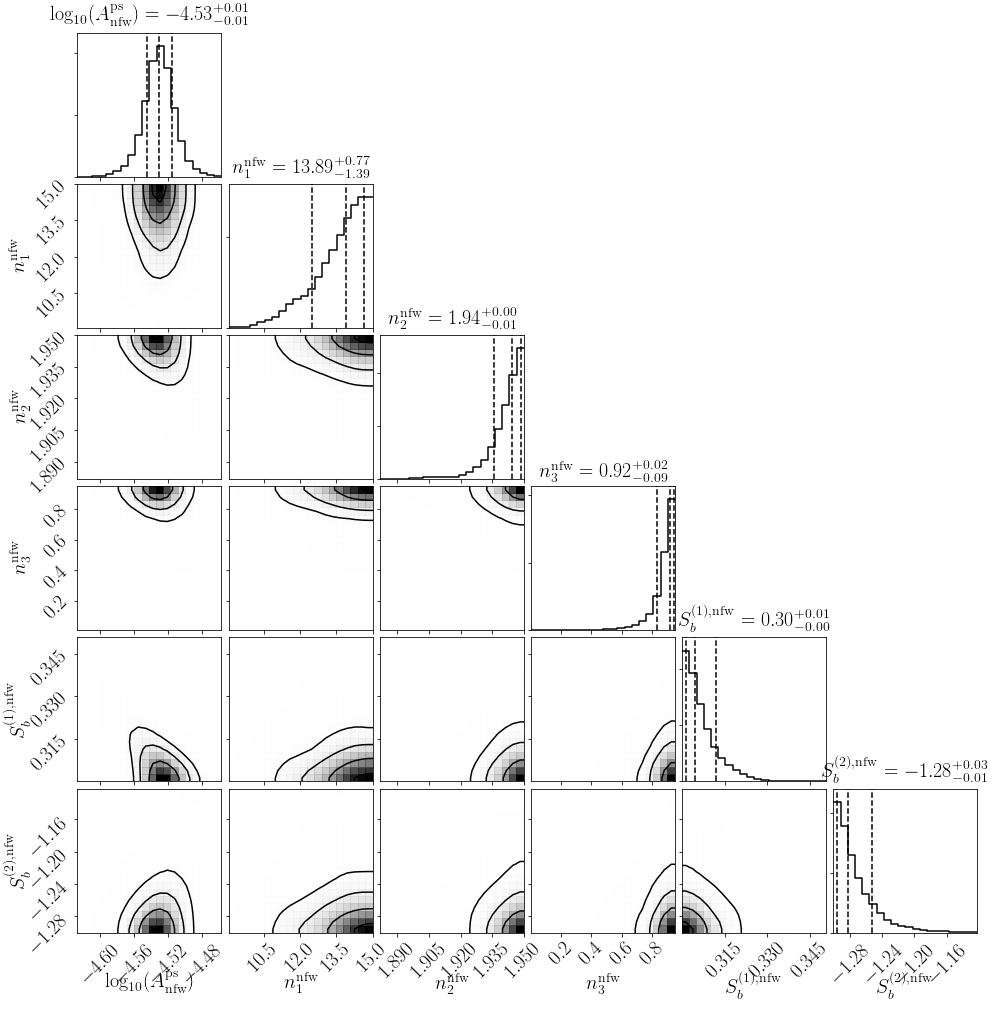

In [58]:
an.make_triangle()
# plt.savefig('plots/DM_PS_tests/corner_40GeV_2em26_PStemp.pdf')

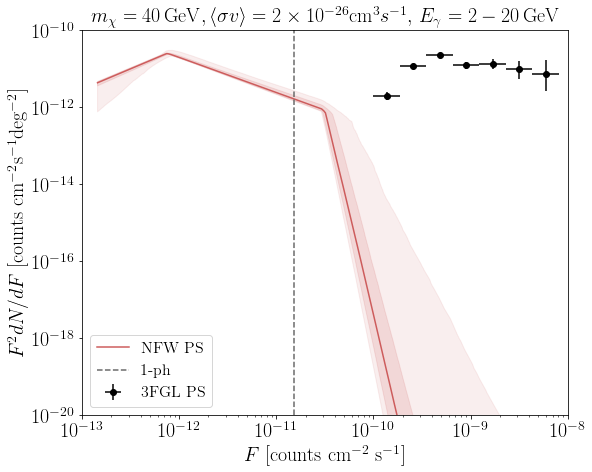

In [72]:
an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray',label='1-ph')
# plt.axvline(10**-1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.title(r'$m_\chi=40\,\mathrm{GeV},\langle\sigma v\rangle=2\times10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/F2dNdF_IG_2break.pdf')
plt.savefig('plots/DM_PS_tests/F2dNdF_40GeV_2em26_PStemp_widepriors.pdf')

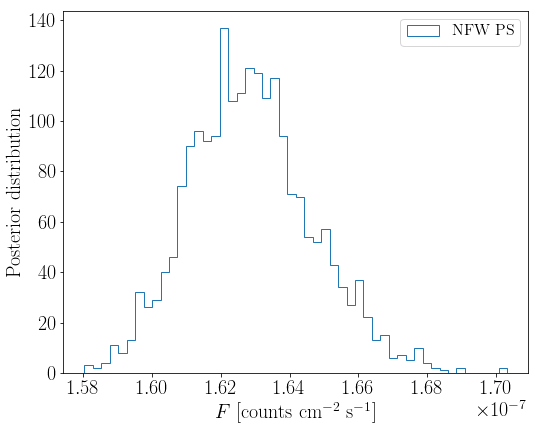

In [62]:
plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=50,histtype='step',label='NFW PS');
# plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=50,histtype='step',label='NFW poiss');
# plt.xscale('log')
# plt.xlim(2e-8,3e-8)
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Posterior distribution')
plt.legend(loc='upper right')
plt.savefig('plots/DM_PS_tests/flux_posterior_40GeV_2em26_PStemp.pdf')